# COMPAS analysis

We recreate the first section of the [Propublica COMPAS analysis](https://github.com/propublica/compas-analysis) in Python. 

What follows are the calculations performed for ProPublica's analaysis of the COMPAS Recidivism Risk Scores. It might be helpful to open [the methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/) in another tab to understand the following.



## Loading the Data

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.



In [1]:
import pandas as pd
import datetime

In [2]:
raw_data = pd.read_csv('./compas-scores-two-years.csv')
print('Num rows: %d' %len(raw_data))

Num rows: 7214


However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:

 - If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
 - We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
 - In a similar vein, ordinary traffic offenses -- those with a df of 'O' -- will not result in Jail time are removed (only two of them).
 - We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
 - We remove rows where there is no score_text ('N/A')

In [3]:
df = raw_data[((raw_data['days_b_screening_arrest'] <=30) & 
      (raw_data['days_b_screening_arrest'] >= -30) &
      (raw_data['is_recid'] != -1) &
      (raw_data['c_charge_degree'] != 'O') & 
      (raw_data['score_text'] != 'N/A')
     )]

print('Num rows filtered: %d' % len(df))

Num rows filtered: 6172


In [4]:
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
7,9,steven stewart,steven,stewart,2013-08-30,Male,1973-02-25,43,25 - 45,Other,...,3,Low,2013-08-30,2014-05-22,2014-06-03,3,0,265,0,0
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
10,14,benjamin franc,benjamin,franc,2013-11-26,Male,1988-06-01,27,25 - 45,Caucasian,...,4,Low,2013-11-26,2013-11-25,2013-11-26,0,0,857,0,0
11,15,ellyaher lanza,ellyaher,lanza,2013-10-03,Male,1992-08-18,23,Less than 25,African-American,...,4,Low,2013-10-03,2013-10-03,2013-10-07,3,4,128,1,1
12,16,kortney coleman,kortney,coleman,2013-01-01,Female,1978-08-22,37,25 - 45,Caucasian,...,1,Low,2013-01-01,2013-01-01,2013-01-02,0,1,1186,0,0


Higher COMPAS scores are slightly correlated with a longer length of stay.



In [5]:
import numpy as np
from datetime import datetime
from scipy.stats import pearsonr

In [6]:
def date_from_str(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

In [7]:
df['length_of_stay'] = (df['c_jail_out'].apply(date_from_str) - df['c_jail_in'].apply(date_from_str)).dt.total_seconds()
stay_score_corr = pearsonr(df['length_of_stay'], df['decile_score'])[0]
print('Correlation btw stay length and COMPAS scores: %.3f' % stay_score_corr)

Correlation btw stay length and COMPAS scores: 0.207


/Users/zaynah.javed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


After filtering we have the following demographic breakdown:

In [8]:
df['age_cat'].value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [9]:
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [10]:
print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [11]:
df['score_text'].value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [12]:
pd.crosstab(df.sex, df.race)

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


In [13]:
df['sex'].value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

In [14]:
print("Men: %.2f%%" %   (4997 / 6172 * 100))
print("Women: %.2f%%" % (1175 / 6172 * 100))

Men: 80.96%
Women: 19.04%


In [15]:
print('Num with two-year recidivism: %d' % len(df['two_year_recid'] == 1))

Num with two-year recidivism: 6172


In [16]:
print('Num with two-year recidivism: %.2f%%' % (len(df[df['two_year_recid'] == 1]) / len(df) * 100.))

Num with two-year recidivism: 45.51%


Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.



In [17]:
%matplotlib inline

from matplotlib import pyplot as plt

Text(0, 0.5, 'Count')

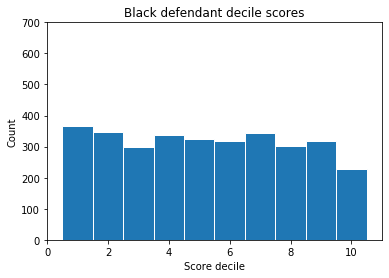

In [18]:
black_df = df[df['race'] == 'African-American']
black_df['decile_score'].hist(edgecolor='white', bins=np.arange(13)-0.5,grid=False)
plt.ylim([0,700])
plt.xlim([0,11])
plt.title('Black defendant decile scores')
plt.xlabel('Score decile')
plt.ylabel('Count')

Text(0.5, 0, 'Score decile')

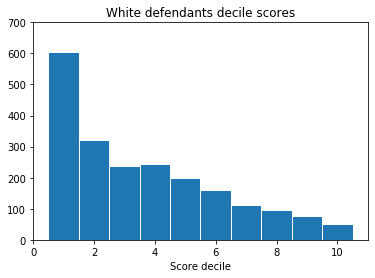

In [19]:
white_df = df[df['race'] == 'Caucasian']
white_df['decile_score'].hist(edgecolor='white', bins=np.arange(13)-0.5,grid=False)
plt.ylim([0,700])
plt.xlim([0,11])
plt.title('White defendants decile scores')
plt.xlabel('Score decile')

In [20]:
pd.crosstab(df.decile_score, df.race)

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


In [51]:
from sklearn.linear_model import LogisticRegression

In [52]:
lr = LogisticRegression(solver='lbfgs')

In [53]:
df_crime = pd.get_dummies(df['c_charge_degree'],prefix='crimefactor',drop_first=True)
df_age = pd.get_dummies(df['age_cat'],prefix='age')
df_race = pd.get_dummies(df['race'],prefix='race')
df_gender = pd.get_dummies(df['sex'],prefix='sex',drop_first=True)
df_score = pd.get_dummies(df['score_text'] != 'Low',prefix='score_factor',drop_first=True)

In [54]:
df_lr = pd.concat([df_crime, df_age,df_race,df_gender,
                   df['priors_count'],df['two_year_recid']
                  ],axis=1)

In [55]:
lr.fit(df_lr,df_score.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
cols = np.concatenate([df_crime.columns.values, 
                df_age.columns.values,
                df_race.columns.values,
                df_gender.columns.values,
                ['priors_count'],
                ['two_year_recid']
               ])

In [27]:
assert len(cols) == len(lr.coef_[0])
print('%.3f' % lr.intercept_, '(Intercept)') 
for i,j in zip(cols, lr.coef_[0]): print('%.3f' % j, i)

-1.335 (Intercept)
-0.310 crimefactor_M
0.018 age_25 - 45
-1.328 age_Greater than 45
1.319 age_Less than 25
0.490 race_African-American
-0.201 race_Asian
0.013 race_Caucasian
-0.409 race_Hispanic
0.909 race_Native American
-0.793 race_Other
-0.219 sex_Male
0.268 priors_count
0.683 two_year_recid


In [28]:
control = np.exp(-1.335) / (1 + np.exp(-1.335))
black_odds = np.exp(0.490) / (1 - control + (control * np.exp(0.490)))
print('Black defendants: %.4f' % black_odds)

Black defendants: 1.4423


In [29]:
def compas_accuracy(y, preds):
    return 1 - (np.count_nonzero(y-preds)/len(preds))

In [42]:
y = pd.get_dummies(df['score_text'] != 'Low',prefix='score_factor',drop_first=True)['score_factor_True']

In [42]:
preds = lr.predict(df_lr)

In [43]:
compas_accuracy(y,preds)

0.7508101101749838

In [60]:
from sklearn.neighbors import KNeighborsClassifier

In [61]:
knn = KNeighborsClassifier()

In [62]:
knn.fit(df_lr,df_score.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [63]:
preds_knn = knn.predict(df_lr)

In [64]:
compas_accuracy(y,preds_knn)

0.754050550874919

In [37]:
from sklearn.neural_network import MLPClassifier

In [38]:
nn = MLPClassifier()

In [39]:
nn.fit(df_lr,df_score.values.ravel())

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [40]:
preds_nn = nn.predict(df_lr)

In [43]:
compas_accuracy(y,preds_nn)

0.7640959170447181

In [48]:
def black_accuracy(model):
    black_df_lr = df_lr[df_lr['race_African-American'] == 1]
    df_black = df[df['race'] == 'African-American']
    black_y = pd.get_dummies(df_black['score_text'] != 'Low',prefix='score_factor',drop_first=True)['score_factor_True']
    black_preds = model.predict(black_df_lr)
    return compas_accuracy(black_y, black_preds)
black_accuracy(nn)

0.7338582677165355

In [50]:
def white_accuracy(model):
    white_df_lr = df_lr[df_lr['race_Caucasian'] == 1]
    df_white = df[df['race'] == 'Caucasian']
    white_y = pd.get_dummies(df_white['score_text'] != 'Low',prefix='score_factor',drop_first=True)['score_factor_True']
    white_preds = model.predict(white_df_lr)
    return compas_accuracy(white_y, white_preds)
white_accuracy(nn)

0.7836424155967665

In [58]:
print('Logistic Regression')
print('Black Accuracy: ', black_accuracy(lr))
print('White Accuracy: ', white_accuracy(lr))

Logistic Regression
Black Accuracy:  0.7269291338582677
White Accuracy:  0.7617689015691869


In [59]:
print('Neural Network')
print('Black Accuracy: ', black_accuracy(nn))
print('White Accuracy: ', white_accuracy(nn))

Neural Network
Black Accuracy:  0.7338582677165355
White Accuracy:  0.7836424155967665


In [65]:
print('K Nearest Neighbors')
print('Black Accuracy: ', black_accuracy(knn))
print('White Accuracy: ', white_accuracy(knn))

K Nearest Neighbors
Black Accuracy:  0.7165354330708662
White Accuracy:  0.776034236804565


In [66]:
def black_ppv(model):
    black_df_lr = df_lr[df_lr['race_African-American'] == 1]
    df_black = df[df['race'] == 'African-American']
    black_y = pd.get_dummies(df_black['score_text'] != 'Low',prefix='score_factor',drop_first=True)['score_factor_True']
    black_preds = model.predict(black_df_lr)
    from sklearn.metrics import precision_score
    return precision_score(black_y, black_preds)

In [67]:
def white_ppv(model):
    white_df_lr = df_lr[df_lr['race_Caucasian'] == 1]
    df_white = df[df['race'] == 'Caucasian']
    white_y = pd.get_dummies(df_white['score_text'] != 'Low',prefix='score_factor',drop_first=True)['score_factor_True']
    white_preds = model.predict(white_df_lr)
    from sklearn.metrics import precision_score
    return precision_score(white_y, white_preds)

In [68]:
print('Logistic Regression')
print('Black PPV: ', black_ppv(lr))
print('White PPV: ', white_ppv(lr))

Logistic Regression
Black PPV:  0.7494813278008299
White PPV:  0.6961770623742455


In [69]:
print('Neural Network')
print('Black PPV: ', black_ppv(nn))
print('White PPV: ', white_ppv(nn))

Neural Network
Black PPV:  0.7633832976445396
White PPV:  0.7304015296367112


In [70]:
print('K Nearest Neighbors')
print('Black PPV: ', black_ppv(knn))
print('White PPV: ', white_ppv(knn))

K Nearest Neighbors
Black PPV:  0.7567716970702045
White PPV:  0.6890756302521008
